In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
#os.getcwd()
os.chdir('/content/drive/My Drive/DL Project')
os.listdir()



['ErensCopy.ipynb',
 'uci-news-aggregator.csv',
 "Juhi'sCopy.ipynb",
 'glove.6B.zip',
 "Elif'sCopy.ipynb",
 'news-category-dataset.zip',
 'News_Category_Dataset_v2.json',
 'glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'Results.gdoc',
 'Notes for DL Project.gdoc',
 'glove.6B.100d.txt.word2vec',
 'NewData ErensCopy.ipynb']

In [30]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


In [31]:
df.category.value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [32]:
df.category.unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [0]:
#Preprocessing taken from Kaggle https://www.kaggle.com/ngyptr/multi-class-classification-with-lstm
#Balancing classes
num_of_categories = 1004 #number of least occuring classes
shuffled = df.reindex(np.random.permutation(df.index))
#create dataframe using first category
cat0 = df.category.unique()[0]
concated = shuffled[shuffled['category'] == cat0][:num_of_categories]

for cat in df.category.unique():
  concated = pd.concat([concated, shuffled[shuffled['category'] == cat][:num_of_categories]], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [16]:
concated.category.value_counts()

CRIME             2008
FIFTY             1004
POLITICS          1004
WORLD NEWS        1004
LATINO VOICES     1004
EDUCATION         1004
HOME & LIVING     1004
MEDIA             1004
CULTURE & ARTS    1004
DIVORCE           1004
QUEER VOICES      1004
WELLNESS          1004
BUSINESS          1004
WEDDINGS          1004
GOOD NEWS         1004
THE WORLDPOST     1004
MONEY             1004
PARENTING         1004
ENTERTAINMENT     1004
RELIGION          1004
BLACK VOICES      1004
FOOD & DRINK      1004
GREEN             1004
PARENTS           1004
STYLE             1004
WOMEN             1004
SPORTS            1004
IMPACT            1004
SCIENCE           1004
TRAVEL            1004
HEALTHY LIVING    1004
WEIRD NEWS        1004
ARTS              1004
COMEDY            1004
TECH              1004
WORLDPOST         1004
TASTE             1004
ENVIRONMENT       1004
ARTS & CULTURE    1004
STYLE & BEAUTY    1004
COLLEGE           1004
Name: category, dtype: int64

In [0]:
#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3

if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

concated.head()


,TITLE,CATEGORY,LABEL
58271,Citi looks perfectly priced – for more mediocrity,b,1
16344,"Buddy-action enough for '22 Jump Street,' but ...",e,0
74854,Japan overhauls its public pension fund,b,1
136469,Computer Used to Create Internet on Display fo...,t,2
94639,"Facebook updates Paper to v1.1, No Android app...",t,2


In [0]:
concated = df
to_drop = []
titles = concated['headline'].values
for i in range(len(titles)):
  if "http" in titles[i]:
    to_drop.append(i)

In [0]:

data = concated.reset_index()
data = data.drop('index', axis=1)
data = data.drop(to_drop)

In [0]:
#labels = to_categorical(data['LABEL'], num_classes=4)
#do this instead of above
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(data['category']), num_classes=len(data.category.unique()))

In [0]:
#we can remove the uncommon words
vocab_size= 50000
t = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~–')
t.fit_on_texts(data['headline'].values)

In [37]:
len(t.word_index)

75626

In [0]:
sequences = t.texts_to_sequences(data['headline'].values)

In [39]:
current_max = 0
max_index = 0
for i in range(len(sequences)):
  m = len(sequences[i])
  if m > current_max:
    current_max=m
    max_index = i
print(current_max)
print(max_index)
    

43
50290


In [0]:
X = pad_sequences(sequences)

In [41]:
len(X), len(labels)

(200852, 200852)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

In [78]:
X_train.shape

(150639, 43)

**Convolutional Net Model**

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [31]:
num_classes= len(data.category.unique())

model = Sequential()
model.add(Embedding(vocab_size, output_dim=100, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#fit
history_LSTM = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
#predict
score_LSTM = model.evaluate(X_test, y_test)

# summarize history for accuracy
plt.plot(history_LSTM.history['acc'])
plt.plot(history_LSTM.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 43, 100)           5000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 41)                4141      
Total params: 5,084,541
Trainable params: 5,084,541
Non-trainable params: 0
_________________________________________________________________


In [33]:
seq_length = 19

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])
model.summary()

#fit
history_Single_CNN = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
#predict
score_Single_CNN = model.evaluate(X_test, y_test)

# summarize history for accuracy
plt.plot(history_Single_CNN.history['acc'])
plt.plot(history_Single_CNN.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_Single_CNN.history['loss'])
plt.plot(history_Single_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 43, 128)           6400000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 41, 128)           49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [0]:
model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(Conv1D(300, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(150, 3, padding='valid',activation='relu',strides=2))
model.add(Conv1D(75, 3, padding='valid',activation='relu',strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(150,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 19, 128)           1280000   
_________________________________________________________________
dropout_27 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 9, 300)            115500    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 4, 150)            135150    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1, 75)             33825     
_________________________________________________________________
flatten_3 (Flatten)          (None, 75)                0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 75)                0         
__________

In [0]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score = model.evaluate(X_test, y_test)
score

Train on 136909 samples, validate on 45637 samples
Epoch 1/5
136909/136909 [==============================] - 104s 762us/step - loss: 0.8350 - acc: 0.6376 - val_loss: 0.5725 - val_acc: 0.7714
Epoch 2/5
136909/136909 [==============================] - 101s 737us/step - loss: 0.5428 - acc: 0.7912 - val_loss: 0.5757 - val_acc: 0.7835
Epoch 3/5
136909/136909 [==============================] - 101s 735us/step - loss: 0.5229 - acc: 0.8006 - val_loss: 0.5052 - val_acc: 0.8067
Epoch 4/5
136909/136909 [==============================] - 100s 733us/step - loss: 0.5411 - acc: 0.7985 - val_loss: 0.5415 - val_acc: 0.7921
Epoch 5/5
45637/45637 [==============================] - 6s 129us/step


[0.5354885565948431, 0.8010605429804764]

In [36]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=X.shape[1]))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(Dropout(0.2))
model_conv.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model_conv.add(Dense(4, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 43, 100)           5000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 39, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 64)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 404       
Total params: 5,098,468
Trainable params: 5,098,468
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_conv.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score = model_conv.evaluate(X_test, y_test)
score

ValueError: ignored

In [16]:
!pip install gensim

    100% |████████████████████████████████| 23.6MB 1.2MB/s 
    100% |████████████████████████████████| 1.4MB 12.1MB/s 
    100% |████████████████████████████████| 133kB 26.6MB/s 
    100% |████████████████████████████████| 61kB 20.6MB/s 
    100% |████████████████████████████████| 5.1MB 5.4MB/s 
    100% |████████████████████████████████| 552kB 23.5MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/23/00/44/e5b939f7a80c04e32297dbd6d96fa3065af89ecf57e2b5f89f
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [57]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [0]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [44]:
from keras.layers import Embedding
word_index = t.word_index
nb_words = min(vocab_size, len(word_index))+1

EMBEDDING_DIM=100

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        try: embedding_matrix[i] = word2vec.word_vec(word)
        except: break
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Null word embeddings: 15306


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 43, 128)           6400000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 41, 128)           49280     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 128)               0         
__________

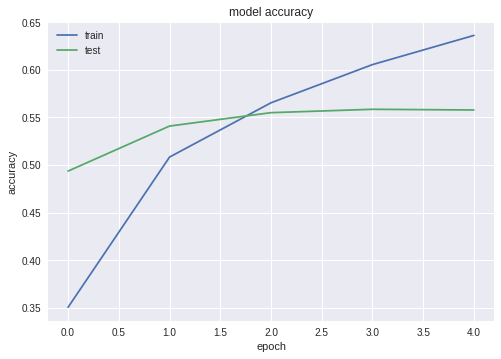

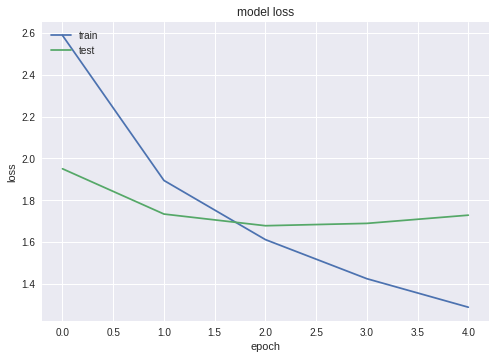

[1.9503925011647192, 1.7340215051988233, 1.678276451010578, 1.689448680546835, 1.728634104388162]
[0.4936968514153548, 0.5409555294350699, 0.5549957182308001, 0.5585406169740746, 0.5578037559935072]


In [82]:
#CNN after word2vec
import matplotlib.pyplot as plt
num_classes= len(data.category.unique())

model = Sequential()

model.add(Embedding(vocab_size, 128, input_length=X.shape[1]))
model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

history_CNN_word2vec = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score_CNN_word2vec = model.evaluate(X_test, y_test)

# summarize history for accuracy
plt.plot(history_CNN_word2vec.history['acc'])
plt.plot(history_CNN_word2vec.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_CNN_word2vec.history['loss'])
plt.plot(history_CNN_word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history_CNN_word2vec.history['val_loss'])
print(history_CNN_word2vec.history['val_acc'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 43, 100)           5000100   
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_14 (Dense)             (None, 41)                4141      
Total params: 5,084,641
Trainable params: 5,084,641
Non-trainable params: 0
_________________________________________________________________
Train on 150639 samples, validate on 50213 samples
Epoch 1/5
150639/150639 [==============================] - 284s 2ms/step - loss: 2.2172 - acc: 0.4188 - val_loss: 1.6614 - val_acc: 0.5362
Epoch 2/5
150639/150639 [==============================] - 283s 2ms/step - loss: 1.6592 - acc: 0.5397 - val_loss: 1.5043 - val_acc: 0.5748
Epoch 3/5
150639/150639 [==============================] - 283s 2ms

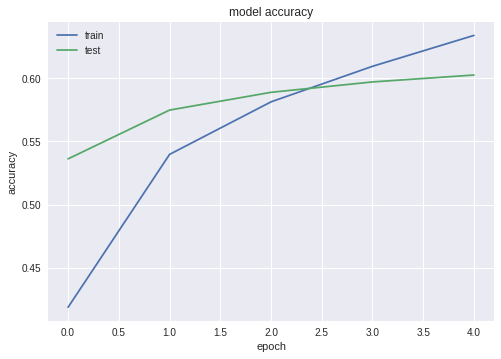

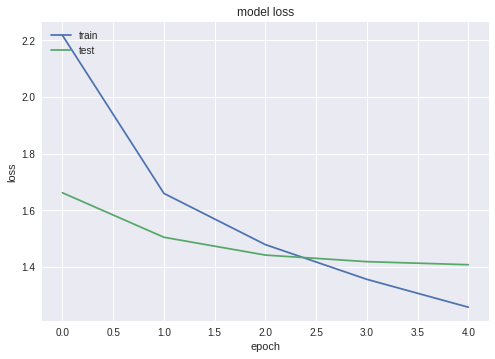

[1.661357258446051, 1.504326549218874, 1.4414109737960017, 1.4181789326410912, 1.407389014639429]
[0.5361758907198386, 0.5747515583637546, 0.588791747135744, 0.5970167087990583, 0.6024734630260513]


In [84]:
#LSTM after word2vec
model = Sequential()
model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history_LSTM_word2vec = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score_LSTM_word2vec = model.evaluate(X_test, y_test)

# summarize history for accuracy
plt.plot(history_LSTM_word2vec.history['acc'])
plt.plot(history_LSTM_word2vec.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_LSTM_word2vec.history['loss'])
plt.plot(history_LSTM_word2vec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print(history_LSTM_word2vec.history['val_loss'])
print(history_LSTM_word2vec.history['val_acc'])



In [0]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)
score = model.evaluate(X_test, y_test)
score

In [0]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y_reg = data['category']

In [0]:
cvscores = {}
loss_vals = {}
val_accs ={}

In [26]:
num_classes= len(data.category.unique())
#cross validation -- beware lasts long
cvscores['CNN_word2vec'] = []
loss_vals['CNN_word2vec'] = []
val_accs['CNN_word2vec'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=num_classes)

  #define the model
  model = Sequential()

  model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
  model.add(Conv1D(128,3,padding='valid',activation='relu',strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(128))
  model.add(Dropout(0.5))
  model.add(Activation('relu'))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['CNN_word2vec'].append(history.history['val_loss'])
  val_accs['CNN_word2vec'].append(history.history['val_acc'])
  cvscores['CNN_word2vec'].append(score[1])
  
  
model.summary()

print(loss_vals['CNN_word2vec'])
print(val_accs['CNN_word2vec'])
print(cvscores['CNN_word2vec'])

Train on 160667 samples, validate on 40185 samples
Epoch 1/5
160667/160667 [==============================] - 190s 1ms/step - loss: 2.4751 - acc: 0.3753 - val_loss: 1.8244 - val_acc: 0.5141
Epoch 2/5
160667/160667 [==============================] - 188s 1ms/step - loss: 1.9430 - acc: 0.4900 - val_loss: 1.6490 - val_acc: 0.5490
Epoch 3/5
160667/160667 [==============================] - 189s 1ms/step - loss: 1.7560 - acc: 0.5286 - val_loss: 1.5863 - val_acc: 0.5619
Epoch 4/5
160667/160667 [==============================] - 188s 1ms/step - loss: 1.6397 - acc: 0.5531 - val_loss: 1.5500 - val_acc: 0.5709
Epoch 5/5
160667/160667 [==============================] - 188s 1ms/step - loss: 1.5481 - acc: 0.5727 - val_loss: 1.5342 - val_acc: 0.5788
Train on 160673 samples, validate on 40179 samples
Epoch 1/5
160673/160673 [==============================] - 189s 1ms/step - loss: 2.4720 - acc: 0.3762 - val_loss: 1.8404 - val_acc: 0.5089
Epoch 2/5
160673/160673 [==============================] - 187s 

In [48]:
num_classes= len(data.category.unique())
#cross validation -- beware lasts long
cvscores['LSTM_word2vec'] = []
loss_vals['LSTM_word2vec'] = []
val_accs['LSTM_word2vec'] = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=num_classes)
  #define the model
  model = Sequential()
  model.add(Embedding(nb_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=X.shape[1]))
  model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(num_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=128)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals['LSTM_word2vec'].append(history.history['val_loss'])
  val_accs['LSTM_word2vec'].append(history.history['val_acc'])
  cvscores['LSTM_word2vec'].append(score[1])
  
  
model.summary()
print(loss_vals['LSTM_word2vec'])
print(val_accs['LSTM_word2vec'])
print(cvscores['LSTM_word2vec'])

Train on 160667 samples, validate on 40185 samples
Epoch 1/5
160667/160667 [==============================] - 311s 2ms/step - loss: 2.1967 - acc: 0.4225 - val_loss: 1.6291 - val_acc: 0.5468
Epoch 2/5
160667/160667 [==============================] - 310s 2ms/step - loss: 1.6529 - acc: 0.5419 - val_loss: 1.4915 - val_acc: 0.5787
Epoch 3/5
160667/160667 [==============================] - 316s 2ms/step - loss: 1.4714 - acc: 0.5827 - val_loss: 1.4376 - val_acc: 0.5915
Epoch 4/5
160667/160667 [==============================] - 314s 2ms/step - loss: 1.3491 - acc: 0.6109 - val_loss: 1.4133 - val_acc: 0.6014
Epoch 5/5
160667/160667 [==============================] - 328s 2ms/step - loss: 1.2555 - acc: 0.6341 - val_loss: 1.3977 - val_acc: 0.6087
Train on 160673 samples, validate on 40179 samples
Epoch 1/5
160673/160673 [==============================] - 347s 2ms/step - loss: 2.1895 - acc: 0.4256 - val_loss: 1.6375 - val_acc: 0.5429
Epoch 2/5
160673/160673 [==============================] - 297s 

**Logistic Regression**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['headline'])

encoder = LabelEncoder()
y = encoder.fit_transform(data['category'])


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(x_test, y_test)))

Accuracy: 0.5859040487523152


In [0]:
CNN_loss = [1.9503925011647192, 1.7340215051988233, 1.678276451010578, 1.689448680546835, 1.728634104388162]
CNN_acc = [0.4936968514153548, 0.5409555294350699, 0.5549957182308001, 0.5585406169740746, 0.5578037559935072]
LSTM_scores = [0.6087097175711347, 0.6074566315788998, 0.6113766492422107, 0.6067818553005029, 0.6030583781511049]
CNN_scores = [0.578822943872668, 0.5754747504900668, 0.5810306198715066, 0.5741423094159239, 0.5768828451764088]

In [0]:
LSTM_word2vec_loss = [1.661357258446051, 1.504326549218874, 1.4414109737960017, 1.4181789326410912, 1.407389014639429]
LSTM_word2vec_acc = [0.5361758907198386, 0.5747515583637546, 0.588791747135744, 0.5970167087990583, 0.6024734630260513]

In [0]:
log_reg_acc = [0.5859040487523152]*len(LSTM_word2vec_loss)

In [13]:
import numpy as np
np.mean(LSTM_scores)
np.mean(CNN_scores)
np.mean(LSTM_word2vec_loss_CV, axis=0)
np.mean(CNN_word2vec_loss_CV, axis=0)

1.5337642915203127

In [0]:
import matplotlib.pyplot as plt 
import numpy as np

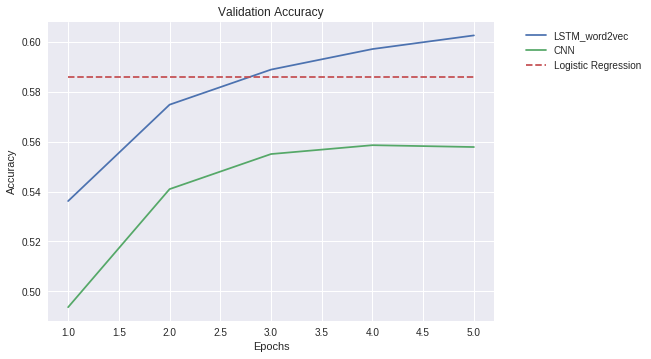

In [9]:
plt.plot(np.arange(1, 6), LSTM_word2vec_acc, label='LSTM_word2vec')
plt.plot(np.arange(1, 6), CNN_acc, label='CNN')
plt.plot(np.arange(1, 6), log_reg_acc, '--', label='Logistic Regression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))

In [0]:
CNN_word2vec_loss_CV = [[1.8244195547598696, 1.6490174970950775, 1.586297431199189, 1.5499959787296629, 1.5342482761733343], [1.8403695317646742, 1.6557722029279738, 1.5855644229438746, 1.5498122366888336, 1.53688921221143], [1.8420424506650626, 1.6430324021043368, 1.5634932991222033, 1.5285745938322215, 1.5168321273087684], [1.8475340754602474, 1.6696921550663073, 1.599461640505797, 1.5587590587440077, 1.5448799493486993], [1.8250451944671937, 1.6582521403968797, 1.583794307972383, 1.5485818467902148, 1.5359718925593313]]
CNN_word2vec_acc_CV = [[0.5141470698792943, 0.548961055075572, 0.561851437052966, 0.5708597736185398, 0.5788229439557303], [0.5088976828498752, 0.5467532789989935, 0.564648199260625, 0.5719654545714213, 0.5754747504144094], [0.5091859596773318, 0.5509584266153591, 0.5672392331874279, 0.576400298659173, 0.5810306198151218], [0.5115520589968862, 0.5442413981618655, 0.5591296121512954, 0.5695115271296295, 0.5741423094574747], [0.5139719067780851, 0.5488145048339473, 0.5650527993980502, 0.5708059374971156, 0.5768828452001603]]
CNN_word2vec_scores_CV = [0.578822943872668, 0.5754747504900668, 0.5810306198715066, 0.5741423094159239, 0.5768828451764088]

In [0]:
LSTM_word2vec_loss_CV =[[1.6291362993245815, 1.4914509705321266, 1.437555567506565, 1.4132540197355825, 1.3976866468559144], [1.637536991689586, 1.490323334200231, 1.4345141162309543, 1.4039444095531393, 1.3937683254469235], [1.628138143439954, 1.4701731815425976, 1.4117289240098516, 1.3887174981845858, 1.3788552359084096], [1.649174214560975, 1.5064239220980575, 1.441274265431434, 1.4157657867936282, 1.4073702499269698], [1.6437968504716258, 1.4959617935463974, 1.437381255458042, 1.4112062830449006, 1.4078050266938704]]
LSTM_word2vec_acc_CV =[[0.546820953105299, 0.578673634517841, 0.5915142466287137, 0.6013935548920707, 0.6087097176334314], [0.5429453196172269, 0.5752009755850829, 0.5918016873715264, 0.6000398218048738, 0.6074566316389807], [0.5460542693018231, 0.5834453572198945, 0.5988050784256318, 0.6053024645940207, 0.6113766492288565], [0.5404571029957456, 0.5756361101102598, 0.5908230842391505, 0.60142906940073, 0.6067818553420538], [0.5421896791714648, 0.5764096434146291, 0.5908547519782454, 0.5987995617012979, 0.6030583781986081]]
LSTM_word2vec_scores_CV =[0.6087097175711347, 0.6074566315788998, 0.6113766492422107, 0.6067818553005029, 0.6030583781511049]

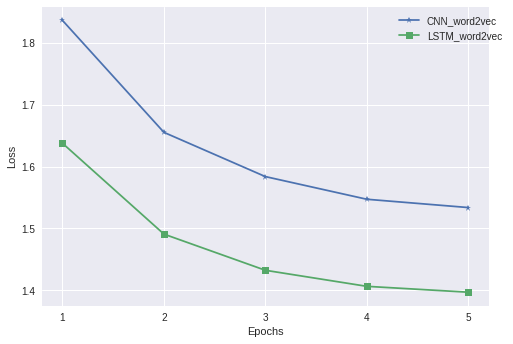

In [51]:
plt.plot(np.arange(1, 6),np.mean(CNN_word2vec_loss_CV, axis=0), '*-', label='CNN_word2vec')
plt.plot(np.arange(1, 6),np.mean(LSTM_word2vec_loss_CV, axis=0),'s-', label='LSTM_word2vec')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([1, 2, 3, 4, 5])
plt.savefig('Validation Loss 5-Fold CV New Data')

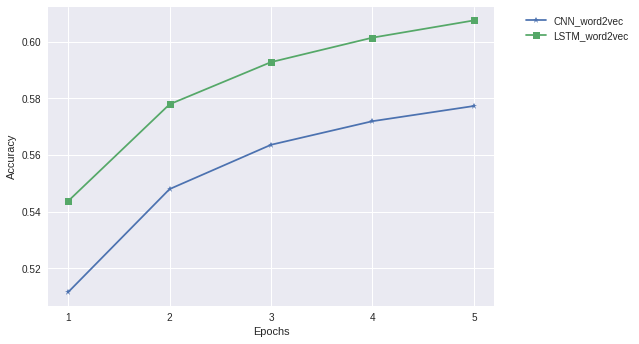

In [52]:
plt.plot(np.arange(1, 6),np.mean(CNN_word2vec_acc_CV, axis=0), '*-', label='CNN_word2vec')
plt.plot(np.arange(1, 6),np.mean(LSTM_word2vec_acc_CV, axis=0), 's-', label='LSTM_word2vec')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks([1, 2, 3, 4, 5])
plt.savefig('Validation Accuracy 5-Fold CV New Data')

In [20]:
from scipy.stats import ranksums

print('LSTM word2vec vs. CNN word2vec:', ranksums(LSTM_word2vec_scores_CV, CNN_word2vec_scores_CV))
print('LSTM word2vec vs. CNN word2vec:', ranksums(l,c))

LSTM word2vec vs. CNN word2vec: RanksumsResult(statistic=2.6111648393354674, pvalue=0.009023438818080326)
LSTM word2vec vs. CNN word2vec: RanksumsResult(statistic=-2.6111648393354674, pvalue=0.009023438818080326)


In [0]:
np.mean(LSTM_word2vec_loss_CV
np.mean(CNN_word2vec_loss_CV, axis=0)

In [0]:
l = []
c = []
for i in range(5):
  l.append(LSTM_word2vec_loss_CV[i][-1])
  c.append(CNN_word2vec_loss_CV[i][-1])

In [18]:
l, c

([1.3976866468559144,
  1.3937683254469235,
  1.3788552359084096,
  1.4073702499269698,
  1.4078050266938704],
 [1.5342482761733343,
  1.53688921221143,
  1.5168321273087684,
  1.5448799493486993,
  1.5359718925593313])